In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate
from glob import glob

#create xarray dataset with saildrone filenames
#data directory for saildrone data
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/saildrone_usv_data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#data direcgtory for temperature logger .csv files
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/temp_log_proc/'
#adir_sbe='F:/data/cruise_data/saildrone/2020_atomic/temp_log_proc/'

#data direcgtory for temperature logger .csv files
figs_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/figs/'

#get list of all filenames in directory
logger_filenames = [x for x in glob(data_dir+'*1_min*.nc')]
#print('number of file:',len(files))
#print(files)

# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [2]:

ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')

# Check what the min/max/mean distance travelled between 1 min obs

In [3]:
for iusv in range(3):
    print(ds.dist_between[iusv,:].min().data,ds.dist_between[iusv,:].max().data,ds.dist_between[iusv,:].mean().data)
#ave distance is 0.08 km = 80 m 

0.0002628831597359855 0.20042159708332527 0.08381687316789584
0.0002626788582655633 0.19503147634695842 0.08436334324573692
8.762569944303782e-05 0.2074201536740167 0.08631113513100724


# Make an evenly sampled timeseries
- Swap the coordinates from time to distance_total
- interp along evenly sampled distance total, 80m (0.08km)

In [4]:
ds_usv = ds.isel(trajectory=0)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
ds4 = ds3.interp(dist_total=dist_interp)

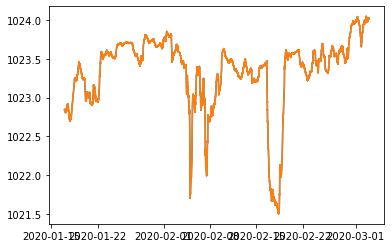

In [5]:
plt.plot(ds2.time,ds3.density_mean)
plt.plot(ds_usv.time,ds_usv.density_mean)


# detrend

In [6]:
from scipy import signal
den = ds4.density_mean.interpolate_na(dim='dist_total')
ds4_detrend = signal.detrend(den)

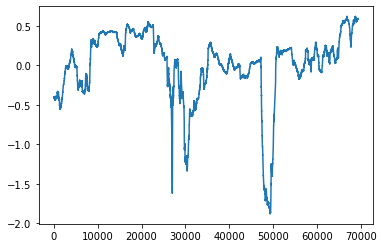

In [7]:
#plt.plot(ds4.density_mean)
#plt.plot(den)
plt.plot(ds4_detrend)

# , smooth using 2km gaussian filter then power density

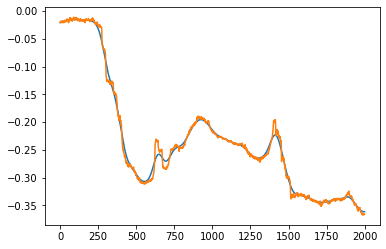

In [8]:
import scipy.ndimage
ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
plt.plot(ds4_detrend_smooth[5000:7000])
plt.plot(ds4_detrend[5000:7000])


Text(0, 0.5, 'PSD [kg/m^3 /km]')

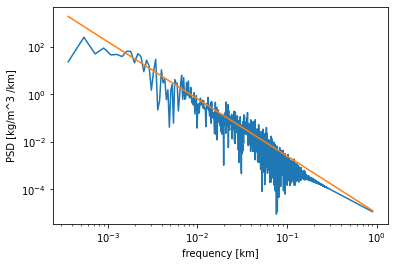

In [9]:
f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[2:5000], Pxx_den[2:5000])
plt.loglog(f[2:5000], f[2:5000]**(-2.4)/100000)
#plt.semilogy(f[2:200], Pxx_den[2:200])
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

# okay, now do all the USV

Text(0, 0.5, 'PSD [kg/m^3 /km]')

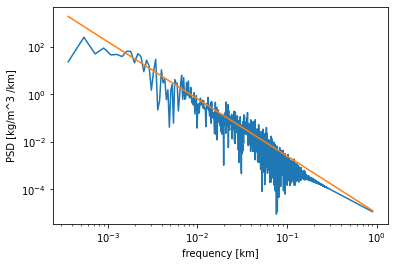

In [10]:
data_all=[]
for iusv in range(3):
    ds_usv = ds.isel(trajectory=0)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    if iusv==0:
        data_all=ds4_detrend_smooth
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[2:5000], Pxx_den[2:5000])
plt.loglog(f[2:5000], f[2:5000]**(-2.4)/100000)
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

In [11]:
#make arrays for sampling at different length scales
length_scale = np.arange(.1,100,1)
# create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
xx_in = np.arange(0,.04,.001)
xx_in2 = np.arange(0,.04-.001,.001)
data = np.zeros((len(length_scale),len(xx_in2)))
ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    for ilen2,len2 in enumerate(length_scale):
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
        ds4 = ds3.interp(dist_total=dist_interp)
        den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
        result,xx = np.histogram(den_grad,bins=xx_in)
        ddn[ilen2,:]=ddn[ilen2,:]+result
for ilen2,len2 in enumerate(length_scale):
    ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100

100 40


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


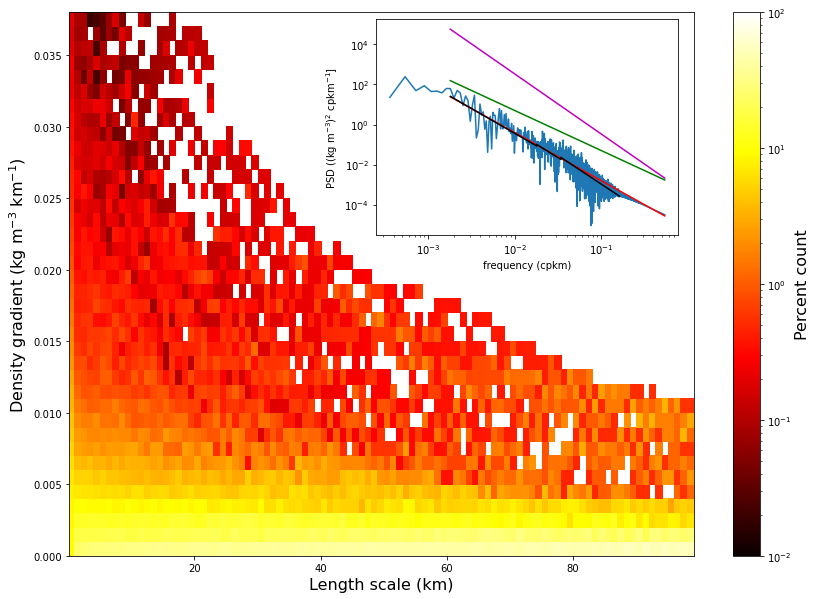

In [91]:
from matplotlib import ticker, cm
import matplotlib.colors as colors
print(len(length_scale),len(xx_in))
fig = plt.figure(figsize=(14,10))
tem=ddn
tem = tem.where(tem>.003)
Z=tem.T
#plt.contourf(length_scale,xx_in2,tem.T*100,vmin=.01,vmax=10,cmap='hot', locator=ticker.LogLocator())
ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
plt.xlabel('Length scale (km)',fontsize=16)
plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
cb = plt.colorbar()
cb.set_label(label='Percent count',fontsize=16)
plt.axes([.43, .57, .3, .3])
f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[2:3000], Pxx_den[2:3000])
plt.loglog(f[10:3000], f[10:3000]**(-2.4)/160000,'r')
plt.loglog(f[10:3000], f[10:3000]**(-2)/2000,'g')
plt.loglog(f[10:3000], f[10:3000]**(-3)/3000,'m')
plt.loglog(f[10:100], f[10:100]**(-2.48)/np.exp(12.44),'k') #test from fit
plt.loglog(f[100:190], f[100:190]**(-2.67)/np.exp(13.03),'k') #test from fit
plt.loglog(f[190:900], f[190:900]**(-2.86)/np.exp(13.44),'k') #test from fit
plt.xlabel('frequency (cpkm)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
plt.savefig(figs_dir+'PSD_den_grad.png')

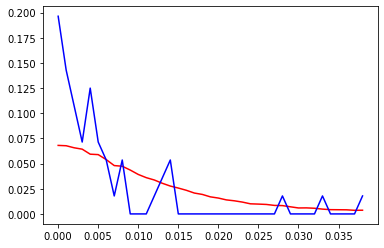

In [13]:
g1=abs(np.gradient(ds2.density_mean))/0.08
g2=abs(np.gradient(ds4.density_mean))/20
r1,x=np.histogram(g1,bins=np.arange(0,0.04,0.001))
r2,x=np.histogram(g2,bins=np.arange(0.,0.04,0.001))
plt.plot(x[:-1],r1/sum(r1),'r')
plt.plot(x[:-1],r2/sum(r2),'b')

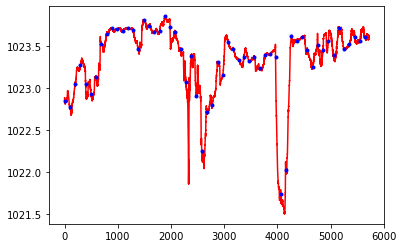

In [14]:
plt.plot(ds2.dist_total,ds2.density_mean,'r')
plt.plot(ds4.dist_total,ds4.density_mean,'b.')

# linear regression

In [85]:
from sklearn.linear_model import LinearRegression
XX = np.log(f[10:100])
YY = np.log(Pxx_den[10:100])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
print(reg.coef_)
print(reg.intercept_)
XX = np.log(f[100:190])
YY = np.log(Pxx_den[100:190])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
print(reg.coef_)
print(reg.intercept_)
XX = np.log(f[190:900])
YY = np.log(Pxx_den[190:900])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
print(reg.coef_)
print(reg.intercept_)

[-2.48267247]
-12.441749833467405
[-2.67352845]
-13.039855644648423
[-2.86965957]
-13.442784466152474


In [88]:
np.exp(12)

162754.79141900392